In [34]:
# standard python imports
import sys
sys.path.append("/home/conradb/git/ifg-ssl")
import math
from collections import Counter, OrderedDict
# from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# pytorch + fastai imports
# from fastai.vision.all import *
import torch
import torchvision
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets
# import torchvision.transforms.functional as F
from torchvision.utils import make_grid

# local module imports
from S1_C1.configs.config import load_global_config
from dino.augment import IfgAugmentationDINO
from dino.loss import DINOLoss
import dino.utils as utils
import dino.vision_transformer as vit
from dino.vision_transformer import DINOHead

In [23]:
config = load_global_config('ifg-ssl/S1_C1/configs/dino_S1_train.toml')
device = torch.device(config.train.device)

In [9]:
transform = IfgAugmentationDINO(tuple(config.crops.global_crops_scale),
                                tuple(config.crops.local_crops_scale),
                                config.crops.local_crops_number,
                                tuple(config.data.mean),
                                tuple(config.data.std))

dataset = datasets.ImageFolder(root=config.data.data_path, transform=transform)

In [10]:
targets = [i for i in dataset.targets]
c = Counter(targets)
print(c)
c = OrderedDict(sorted(c.items()))
print(c)

length = 0
for value in c.values():
    length += int(value)
print(length)

# calcuate weight of each class
class_weights = [1.0/n for n in c.values()]
print(class_weights)

# assign weight to each sample
sample_weights = [class_weights[n] for n in dataset.targets]
print(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# assign sampler
train_dataloader = DataLoader(dataset,
                              sampler=sampler,
                              batch_size=config.train.batch_size,
                              num_workers=config.train.num_workers,
                              pin_memory=config.train.pin_memory,
                              drop_last=True)

Counter({0: 7386, 1: 150})
OrderedDict([(0, 7386), (1, 150)])
7536
[0.00013539128080151638, 0.006666666666666667]
[0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.00013539128080151638, 0.0001353912808015163

In [11]:
one_sample = next(iter(train_dataloader))
print(len(one_sample[0])) # crops
print(len(one_sample[1])) # labels
print(one_sample[0][9].shape)

10
128
torch.Size([128, 3, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


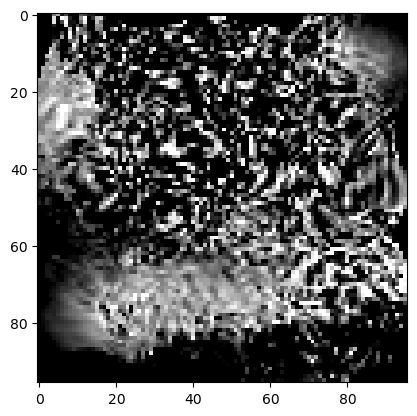

In [12]:
plt.imshow(one_sample[0][9][43].permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


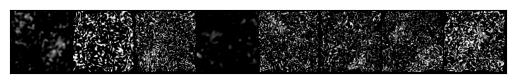

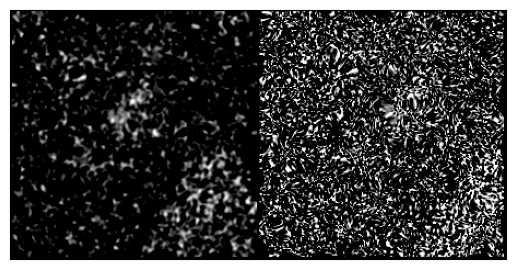

In [18]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.permute(1,2,0)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


list_local = [*one_sample[0][2:10]] # grab local crops
list_global = [*one_sample[0][0:2]] # grab global crops
grid_local = make_grid([a[99] for a in list_local], nrow=8) # where n in a[n] is a batch sample
grid_global = make_grid([a[99] for a in list_global], nrow=2) # where n in a[n] is a batch sample
show(grid_local)
show(grid_global)
print(one_sample[1][100])

In [20]:
print(list_global[0][110][2])

tensor([[-1.8837, -1.8837, -1.8693,  ..., -1.6816, -1.7827, -1.6961],
        [-1.8837, -1.8837, -1.8693,  ..., -0.4981, -1.0899, -0.6857],
        [-1.8837, -1.8837, -1.8693,  ...,  0.2092, -0.2960, -0.3104],
        ...,
        [-1.6816, -0.5703,  0.1947,  ..., -1.1765, -0.4692, -0.2671],
        [-1.7827, -1.0754, -0.3682,  ..., -1.7971, -1.6239, -1.5950],
        [-1.8404, -1.4218, -0.6280,  ..., -1.8837, -1.8548, -1.8548]])


In [39]:
####### COMPUTE MEAN / STD

train_dataloader = DataLoader(dataset,
                              batch_size=config.train.batch_size,
                              num_workers=config.train.num_workers,
                              pin_memory=config.train.pin_memory,
                              drop_last=True)

# placeholders
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs, _ in train_dataloader:
    psum += inputs.sum(axis=[0, 2, 3])
    psum_sq += (inputs**2).sum(axis=[0, 2, 3])

# pixel count
count = (len(train_dataloader)*128) * 224 * 224 #n_batches x batch_size x pixel height x pixel width

# mean and std
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

# output
print("mean: " + str(total_mean))
print("std:  " + str(total_std))

mean: tensor([0.5118, 0.5118, 0.5118])
std:  tensor([0.2717, 0.2717, 0.2717])


In [41]:
print(total_std*255)

tensor([69.2836, 69.2836, 69.2836])


In [25]:
student = vit.__dict__[config.model.model](patch_size=16, drop_path_rate=0.1)
teacher = vit.__dict__[config.model.model](patch_size=16)
embed_dim = student.embed_dim
# multi-crop wrapper handles forward with inputs of different resolutions
student = utils.MultiCropWrapper(student, DINOHead(embed_dim, config.model.out_dim, use_bn=config.model.use_bn_head, norm_last_layer=config.model.norm_last_layer))
teacher = utils.MultiCropWrapper(teacher, DINOHead(embed_dim, config.model.out_dim, use_bn=config.model.use_bn_head))

student, teacher = student.to(device), teacher.to(device)

teacher.load_state_dict(student.state_dict())

for p in teacher.parameters():
    p.requires_grad = False

<All keys matched successfully>

In [32]:
dino_loss = DINOLoss(
    config.model.out_dim,
    config.crops.local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
    config.DINO.warmup_teacher_temp,
    config.DINO.teacher_temp,
    config.DINO.warmup_teacher_temp_epochs,
    config.train.epochs,
    ).to(device)

params_groups = utils.get_params_groups(student)
optimizer = torch.optim.AdamW(params_groups)  # to use with ViTs

lr_schedule = utils.cosine_scheduler(config.train.lr, config.train.min_lr, config.train.epochs, len(train_dataloader), warmup_epochs=config.train.warmup_epochs)

wd_schedule = utils.cosine_scheduler(config.train.weight_decay, config.train.weight_decay_end, config.train.epochs, len(train_dataloader))

# momentum parameter is increased to 1. during training with a cosine schedule
momentum_schedule = utils.cosine_scheduler(config.DINO.momentum_teacher, 1, config.train.epochs, len(train_dataloader))

In [35]:
scaler = torch.cuda.amp.GradScaler()

for epoch in range(0, config.train.epochs):

    running_loss = 0
    counts = 0

    for itr, (batch, _) in enumerate(train_dataloader):

        images = [image.to(device) for image in batch]

        it = len(train_dataloader) * epoch + itr  # global training iteration

        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # teacher and student forward passes + compute dino loss
        with torch.cuda.amp.autocast():
            teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
            student_output = student(images)
            loss = dino_loss(student_output, teacher_output, epoch)

        running_loss += loss.detach().cpu().numpy()
        counts += 1

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            sys.exit(1)

        # student update
        optimizer.zero_grad()
        param_norms = None
        scaler.scale(loss).backward()
        #loss.backward()

        #param_norms = utils.clip_gradients(student, 3.0)
        utils.cancel_gradients_last_layer(epoch, student, 1)

        scaler.step(optimizer)
        scaler.update()

        #optimizer.step()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)
                
        if itr == 0:
            if epoch % 5 == 0:
                
                save_dict = {
                        'student': student.state_dict(),
                        'teacher': teacher.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'epoch': epoch + 1,
                        'dino_loss': dino_loss.state_dict(),
                        }
                # print('saving checkpoint')
                # torch.save(save_dict, 'dino/dino_checkpoints/t60pct_hephaestus_ViTS16_ckpt_v1.pth')

    epoch_loss = running_loss / counts
    print(f'Epoch {epoch} loss is {epoch_loss}')

/home/conradb/mambaforge/envs/ml/lib/python3.9/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 0 loss is 5.835132409786356
